In [4]:
from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

import pickle

In [21]:
dp_mix_stan = """
data
{
    int I; // number of areal locations
    int T; // number of time steps
    int P; // number of covariates
    int H; // truncation of stick breaking construction dp
    
    array[I] vector[T] y; // value of interest
    array[I] matrix[T,P+1] X; // covariates matrices for each province
      
    // hyperpar vector of regressors
    vector[P+1] mu_0; 
    real        sigma_0;
    
    // mean of w_1 (random effect for every province at time 1)
    vector[I] mu_w_1;
    
    // alpha
    real a_alpha;
    real b_alpha;
    
    // tau^2
    real a_tau2;
    real b_tau2;
    
    // sigma^2
    real a_sigma2;
    real b_sigma2;
    
    // rho 
    real rho;
    
    //xis
    real a_xi;
    real b_xi;

    // Qinv
    matrix[I,I] inv_Q;
}

transformed data {
    matrix[I, I] L;
    L = cholesky_decompose(inv_Q);
}

parameters
{
    real<lower=0> alpha;
    real<lower=0> sigma2; 
    real<lower=0> tau2;  
    
    // autoregressive coefficient construction
    real<lower=0,upper=1> xi_constructor;
    
    // betas for the mixture of the dirichlet process
    array[H] vector[P+1] betas; 

    // for the construction of the dirichlet process
    vector<lower=0,upper=1>[H-1] vs;
    
    // for the random effect construction 
    array[T] vector[I] w_raw;
}

transformed parameters
{   
    // weights stick breaking construction
    simplex[H] omegas; 
    
    // sbc stuff
    vector[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];
    
    // autoregressive coefficient of the random effects
    real xi = 2*xi_constructor-1;
    
    // random effects tmp
    matrix[I,T]                ws_tmp;
    
    ws_tmp[1:I,1] =  mu_w_1 + L*w_raw[1];
    
    for (t in 2:T)
        ws_tmp[1:I,t] = ws_tmp[1:I,t-1]*xi + L*w_raw[t]; 
    
    matrix[T,I]   ws = (ws_tmp)'; //otherwise I have to transpose in the for loop at each iteration
    
    // Stan wants std
    real sigma = sqrt(sigma2);
    real tau = sqrt(tau2);
}

model
{
    alpha  ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    vs     ~ beta(1,alpha); 
    xi_constructor ~ beta(a_xi,b_xi);
    
    w_raw[1] ~ normal(0, tau); 
    
    for (t in 2:T)
        w_raw[t] ~ normal(0, tau);
    
    for (h in 1:H)
        betas[h] ~ normal(mu_0, sigma_0);
    
    vector[H] log_probs;
    
    for (i in 1:I) {
        
        for (h in 1:H) 
    
            log_probs[h] = log(omegas[h]) + normal_lpdf(y[i] | X[i]*betas[h] + ws[1:T,i], sigma);
        
        target += log_sum_exp(log_probs);
    }
}

generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    // log likelihood for each areal location 
    vector[I] log_lik;
    
    array[I] vector[H] log_probs;
    
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + normal_lpdf(y[i] | X[i]*betas[h] + ws[1:T,i], sigma);
        
        s[i] = categorical_rng(softmax(log_probs[i]));
        
        log_lik[i] = log_sum_exp(log_probs[i]);
    }
    
        
}
"""

stan_file = "Sp_corr.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)

15:10:35 - cmdstanpy - INFO - compiling stan file /home/riccardo/bayesian-project/Sp_corr.stan to exe file /home/riccardo/bayesian-project/Sp_corr
15:11:06 - cmdstanpy - INFO - compiled model executable: /home/riccardo/bayesian-project/Sp_corr


In [ ]:
#The cell below is the simulated dataset from the paper (10x10)

(100, 10, 4)
(100, 10)
[[0. 0. 2. 2. 2. 2. 4. 4. 5. 5.]
 [0. 0. 2. 2. 2. 2. 4. 4. 5. 5.]
 [1. 1. 1. 1. 2. 2. 4. 4. 5. 5.]
 [1. 1. 1. 1. 2. 2. 4. 4. 4. 4.]
 [1. 1. 1. 1. 3. 3. 3. 4. 4. 4.]
 [1. 1. 1. 1. 3. 3. 3. 4. 4. 4.]
 [1. 1. 1. 1. 4. 4. 4. 4. 4. 4.]
 [1. 1. 1. 1. 4. 4. 4. 4. 4. 4.]
 [1. 1. 1. 1. 6. 6. 6. 6. 6. 6.]
 [1. 1. 1. 1. 6. 6. 6. 6. 6. 6.]]
230.50340783675534
7.574283703779425
(100, 10, 4)


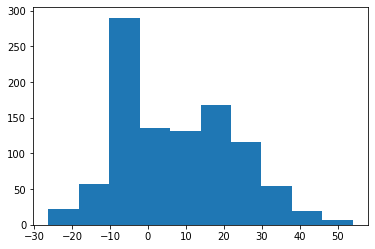

In [6]:
np.random.seed(120) 

I = 100
T = 10
P = 3
num_clus = 7
# means = np.array([-5, 0, 5, 3, -3, -10, 10]) #vector of possible mean 
true_beta_means=np.array([[0.2, 0.2 ,0.2,0.2],[-1, -1 , -1,-1],[3, 3 ,3,3],[-2,-2,-2,-2],[5,5,5,5],[-4,-4,-4,-4],
                   [4,4,4,4]])
W_raw= np.zeros((I,I))
true_clus=np.zeros((I,1),int)

beta = np.zeros((num_clus,P+1))
for i in range(num_clus):
    beta[i,0:] = np.random.multivariate_normal(mean=true_beta_means[i],cov = np.eye(P+1));
    
#Put the i in a matrix(10x11) saved by the sequence of rows
# W(i,j)=1 if i and j have a shared side or corner
# Divided in 7 groups as in paper
Square_clus= np.zeros((10,10))
Square_clus[2:,0:4]=np.ones((8,4))
Square_clus[0:2,2:4]=2*np.ones((2,2))
Square_clus[0:8,4:]=4*np.ones((8,6))
Square_clus[0:4,4:6]=2*np.ones((4,2))
Square_clus[0:3,8:]=5*np.ones((3,2))
Square_clus[4:6,4:7]=3*np.ones((2,3))
Square_clus[8:,4:]=6*np.ones((2,6))
for i in range(I):
    W_raw[i,i]=1
    col_ind_i=int(i%10)
    row_ind_i=int((i-col_ind_i)/10)
    true_clus[i]= Square_clus[row_ind_i,col_ind_i]
    for j in range(i):
        col_ind_j=int(j%10)
        row_ind_j=int((j-col_ind_j)/10)
        
        if(abs(row_ind_i-row_ind_j)<=1 and abs(col_ind_i-col_ind_j)<=1):
            W_raw[i,j]=1
            W_raw[j,i]=1
            
#Build X random
X_tmp = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
  X_tmp[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly

X = []
for i in range(I):
    X.append(X_tmp[T*(i):T*(i+1),0:])
    
X = np.array(X)
print(X.shape)

#Build xis
tau2=0.1
rho=0.95
v=np.matmul(W_raw,np.ones((I,1)))
v=np.reshape(v,I)
invQ=np.linalg.inv(rho*(np.diag(v)-W_raw)+(1-rho)*np.eye(I))
diag_matrix_xis=0.05*np.eye(I) #diag(xis) 

for i in range(I):
  for j in range(I):
    invQ[j,i] = invQ[i,j]

#Build W temporal autoregressive element
W=np.zeros((I,T))
W[:,0]=np.random.multivariate_normal(mean=np.zeros(I),cov=invQ*tau2)
for t in range(T-1):
    W[:,t+1]=np.random.multivariate_normal(mean=np.matmul(diag_matrix_xis,W[:,t]), cov=invQ*tau2)

#Build y
y = []
y_temp = np.zeros(T)
for i in range(I): #for each areal location 
    loc= np.matmul(X[i],np.transpose(beta[true_clus[i],:]))+ np.reshape(W[i,:],(10,1))
    y_temp = np.random.multivariate_normal(mean= np.squeeze(loc), cov=np.eye(T))
    y.append(y_temp)
    # this are the data related to areal i for all time until T
    
y = np.array(y)
print(y.shape)
print(Square_clus)
plt.hist(np.reshape(y,(I*T,1)))
# print(np.linalg.eig(invQ))

print(np.var(np.reshape(y,(I*T,1))))
print(np.mean(np.reshape(y,(I*T,1))))
print(X.shape)


In [7]:
mu_0 = np.zeros(P+1) #as in the paper
mu_w_1 = np.zeros(I) #as in the paper
sigma_0 = 1 #covariance matrix
H = 10

data = {
    "I": I,
    "T": T,
    "P": P,
    "H": H,
    "y": y,
    "X": X,
    "mu_0": mu_0,
    "sigma_0": sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "rho": 0.95,
    "a_xi": 1,
    "b_xi": 1,
    "inv_Q": invQ
}

In [23]:
num_chains = 4
num_iter = 2000
fit = dp_mix.sample(data
                    , iter_warmup = 2000
                    , iter_sampling = num_iter
#                    , adapt_init_phase = 1500
#                    , adapt_metric_window = 1500
#                    , adapt_step_size = 1500
#                  , show_console = True
#                     , chains= num_chains
#                    , adapt_delta=0.9
#                    , step_size = 0.2
#                    , max_treedepth = 100
                   )

15:12:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:18:35 - cmdstanpy - INFO - CmdStan done processing.
15:18:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/home/riccardo/bayesian-project/Sp_corr.stan', line 100, column 4 to column 36)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/riccardo/bayesian-project/Sp_corr.stan', line 106, column 4 to column 30)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/riccardo/bayesian-project/Sp_corr.stan', line 100, column 4 to column 36)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/riccardo/bayesian-project/Sp_corr.stan', line 106, column 4 to column 30)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/riccardo/bayesian-project/Sp_corr.stan', line 106, column 4 to column 30)
Consider re-running with show_console=True if the above output is unclear!


In [24]:
fit.diagnose() #questa cosa che dice non capisco quanto fa male :(

'Processing csv files: /tmp/tmplvobebxi/Sp_corrb8t334tk/Sp_corr-20230129151211_1.csv, /tmp/tmplvobebxi/Sp_corrb8t334tk/Sp_corr-20230129151211_2.csv, /tmp/tmplvobebxi/Sp_corrb8t334tk/Sp_corr-20230129151211_3.csv, /tmp/tmplvobebxi/Sp_corrb8t334tk/Sp_corr-20230129151211_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nThe E-BFMI, 0.07, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.\nIf possible, try to reparameterize the model.\n\nThe following parameters had fewer than 0.001 effective draws per transition:\n  alpha, betas[1,1], betas[2,1], betas[3,1], betas[5,1], betas[6,1], betas[7,1], betas[8,1], betas[9,1], betas[1,2], betas[2,2], betas[3,2], betas[4,2], betas[5,2], betas[6,2], betas[7,2], betas[8,2], betas[9,2], betas[10,2], beta

In [180]:
s = (fit.s).astype(int)

np.savetxt("posterior_s.csv", s, delimiter=",")
s.shape

(8000, 100)

/home/riccardo/.local/lib/python3.9/site-packages/arviz/plots/traceplot.py:215: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (40), generating only 20 plots
  warnings.warn(


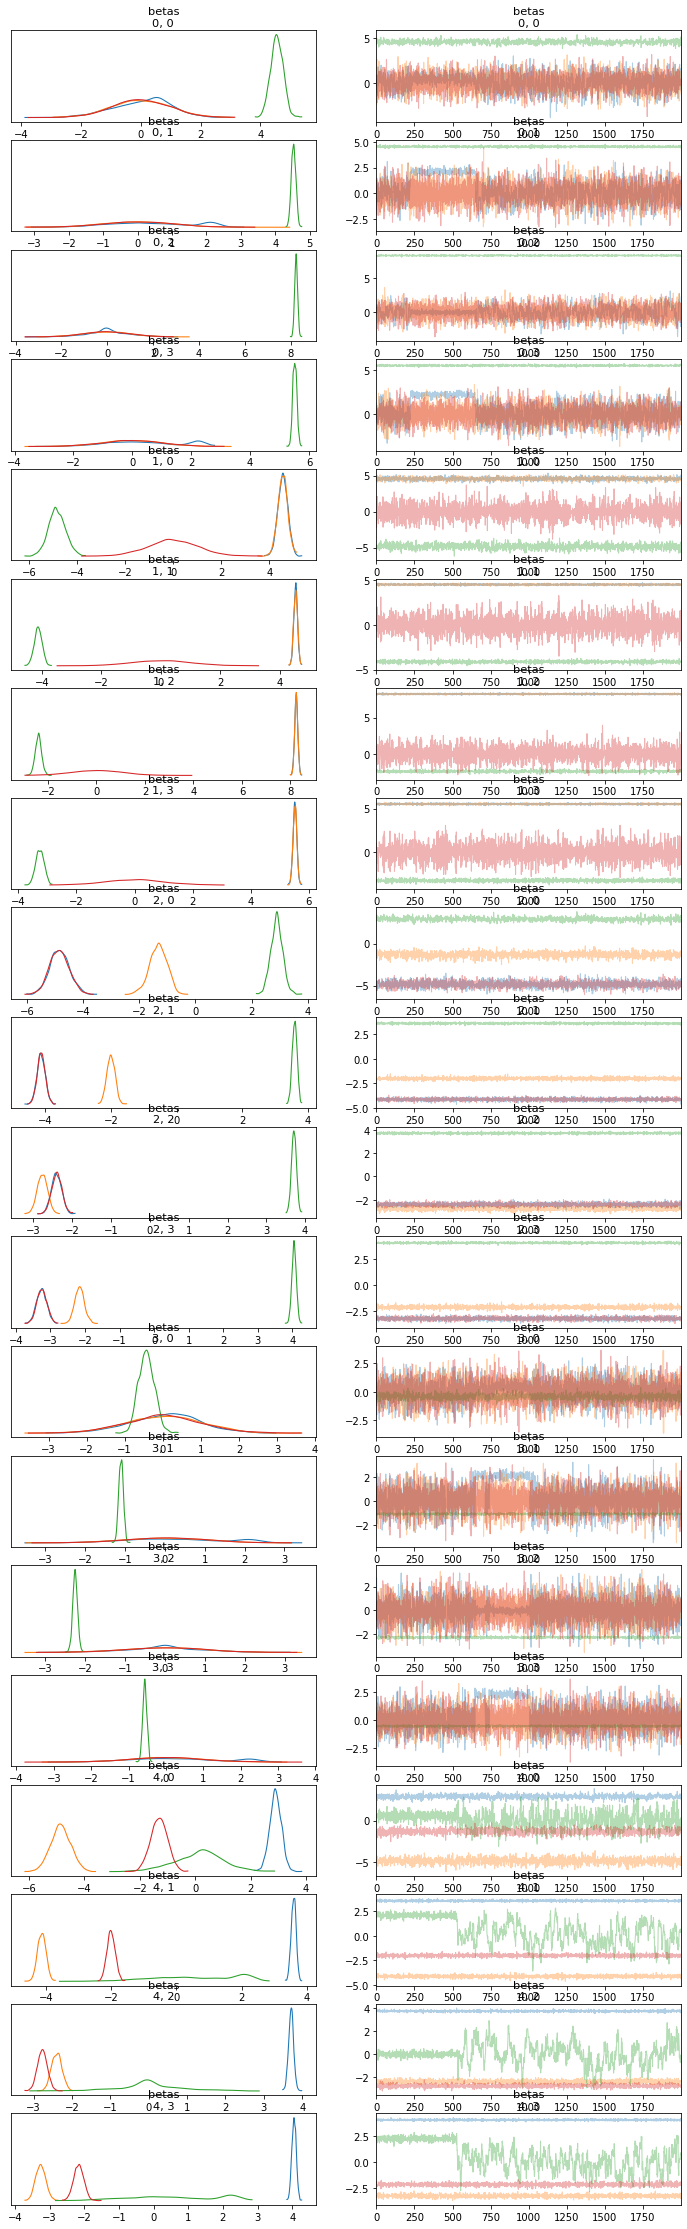

In [25]:
fit_az = az.from_cmdstanpy(fit)
az.plot_trace(fit_az,var_names=["betas"], compact = False)
plt.show()

In [ ]:
fit_az = az.from_cmdstanpy(fit)
az.plot_posterior(fit_az,var_names=["betas"])
plt.show()

In [ ]:
az.plot_autocorr(fit_az)
plt.show()
# alcuni autocorrelation plot dei beta fanno schifo :(

In [207]:
az.ess(fit_az)
# non sembrano male ma non saprei 

<xarray.Dataset>
Dimensions:               (betas_dim_0: 10, betas_dim_1: 4, vs_dim_0: 9,
                           w_raw_dim_0: 100, omegas_dim_0: 10,
                           cumprod_one_mv_dim_0: 9, ws_tmp_dim_0: 100,
                           ws_tmp_dim_1: 10, ws_dim_0: 10, ws_dim_1: 100,
                           means_dim_0: 10, means_dim_1: 100, means_dim_2: 10,
                           s_dim_0: 100, log_probs_dim_0: 100,
                           log_probs_dim_1: 10)
Coordinates: (12/16)
  * betas_dim_0           (betas_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * betas_dim_1           (betas_dim_1) int64 0 1 2 3
  * vs_dim_0              (vs_dim_0) int64 0 1 2 3 4 5 6 7 8
  * w_raw_dim_0           (w_raw_dim_0) int64 0 1 2 3 4 5 ... 94 95 96 97 98 99
  * omegas_dim_0          (omegas_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * cumprod_one_mv_dim_0  (cumprod_one_mv_dim_0) int64 0 1 2 3 4 5 6 7 8
    ...                    ...
  * means_dim_0           (means_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * means_dim_1           (means_dim_1) int64 0 1 2 3 4 5 ... 94 95 96 97 98 99
  * means_dim_2           (means_dim_2) int64 0 1 2 3 4 5 6 7 8 9
  * s_dim_0               (s_dim_0) int64 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
  * log_probs_dim_0       (log_probs_dim_0) int64 0 1 2 3 4 5 ... 95 96 97 98 99
  * log_probs_dim_1       (log_probs_dim_1) int64 0 1 2 3 4 5 6 7 8 9
Data variables: (12/17)
    alpha                 float64 10.76
    sigma2                float64 7.148
    tau2                  float64 7.178
    xi_constructor        float64 12.72
    betas                 (betas_dim_0, betas_dim_1) float64 4.897 ... 5.324
    vs                    (vs_dim_0) float64 5.803 6.181 5.033 ... 6.052 70.88
    ...                    ...
    ws                    (ws_dim_0, ws_dim_1) float64 26.59 48.06 ... 7.127
    sigma                 float64 7.148
    tau                   float64 7.178
    means                 (means_dim_0, means_dim_1, means_dim_2) float64 4.6...
    s                     (s_dim_0) float64 33.67 33.51 4.016 ... 4.016 4.016
    log_probs             (log_probs_dim_0, log_probs_dim_1) float64 4.929 .....

In [30]:
fit_az.posterior.s.values[0,1999,:]
print(fit_az.posterior.s.values[0,1999,:])
print(np.reshape(true_clus,(1,100))[0])


[6. 6. 5. 5. 5. 5. 2. 2. 3. 3. 6. 6. 5. 5. 5. 5. 2. 2. 3. 3. 7. 7. 7. 7.
 5. 5. 2. 2. 3. 3. 7. 7. 7. 7. 5. 5. 2. 2. 2. 2. 7. 7. 7. 7. 8. 8. 8. 2.
 2. 2. 7. 7. 7. 7. 8. 8. 8. 2. 2. 2. 7. 7. 7. 7. 2. 2. 2. 2. 2. 2. 7. 7.
 7. 7. 2. 2. 2. 2. 2. 2. 7. 7. 7. 7. 5. 5. 5. 5. 5. 5. 7. 7. 7. 7. 5. 5.
 5. 5. 5. 5.]
[0 0 2 2 2 2 4 4 5 5 0 0 2 2 2 2 4 4 5 5 1 1 1 1 2 2 4 4 5 5 1 1 1 1 2 2 4
 4 4 4 1 1 1 1 3 3 3 4 4 4 1 1 1 1 3 3 3 4 4 4 1 1 1 1 4 4 4 4 4 4 1 1 1 1
 4 4 4 4 4 4 1 1 1 1 6 6 6 6 6 6 1 1 1 1 6 6 6 6 6 6]


In [68]:
with open("spatially_correlated_simulated_dataset.pkl", "wb") as f:
    pickle.dump({'model' : dp_mix, 'fit' : fit}, f, protocol=-1)
    # or with a list
    pickle.dump([dp_mix, fit], f, protocol=-1)
fit_az = az.from_cmdstanpy(fit)

In [ ]:
#Extimate pi[i,j] to compute Binder loss
#Likely not the most clever way to compute the matrix

n_iteration_per_chain= num_iter
Binder_matrix= np.zeros((I,I))
for n in range(num_chains):
    for m in range(n_iteration_per_chain):
        for i in range(I):
            for j in range(i-1):
                if(fit_az.posterior.s.values[n,m,i]==fit_az.posterior.s.values[n,m,j]):
                    Binder_matrix[i,j]+=1
                
Binder_matrix= Binder_matrix/(n_chains*n_iteration_per_chain)


In [11]:
#define Binder Loss

#Commented I added a penalty for a large number of clusters
#With penalty_n_clus=0 standard binder loss

def binder_function(binder_alloc):
    loss=0
    #penalty_n_clus=1
    #loss=penalty_n_clus*np.unique(binder_alloc).size
    
    for i in range(I):
        for j in range(i):
            
            if(binder_alloc[i]==binder_alloc[j]):
                    loss+=(1-Binder_matrix[i,j])
            
            else:
                loss+=(Binder_matrix[i,j])
            
    return loss

    

In [12]:
#Minimize Binder Loss evaluating the loss only 
#in the solutions found by stan model
#Not completly correct but should be a good doable approximation
n_chains=4
iteration_per_chain=1000
min_loss=10000
s_fixed=np.zeros(I)
for n in range(n_chains):
    for m in range(iteration_per_chain):
        loss=binder_function(fit_az.posterior.s.values[n,m])
        if(loss<min_loss):
            s_fixed=fit_az.posterior.s.values[n,m]

print('S_fixed')
print(s_fixed)


S_fixed
[ 8. 10.  9.  6.  7.  1.  2.  7.  1. 10. 10.  6.  1. 10. 10.  1.  7.  7.
  2.  1.  1.  9.  8.  6.  1.  6.  2.  4.  2.  7.  7.  3.  1. 10.  6.  9.
  4.  8.  3.  2.  1.  3.  5.  4.  4.  5.  8.  2.  7.  9.  8.  1.  3.  8.
  3.  8.  5.  1.  5.  7.  6. 10.  4. 10.  7.  7.  2. 10. 10.  5. 10.  8.
  3.  3.  2.  5.  5.  3.  3.  9.  7.  5. 10.  6. 10.  1.  1.  1. 10.  1.
 10.  1.  1.  2.  1. 10. 10. 10. 10.  3.]


In [36]:
# Fixed clustering s to study betas depending on clusters
beta_clus_stan = """
data
{
    int I; // number of areal locations
    int T; // number of time steps
    int P; // number of covariates
    int N; // number of clusters
    
    array[I] vector[T] y; // value of interest
    array[I] matrix[T,P+1] X; // covariates matrices for each province
      
    // hyperpar vector of regressors
    vector[P+1] mu_0; 
    real        sigma_0;
    
    // mean of w_1 (random effect for every province at time 1)
    vector[I] mu_w_1;
    
    // alpha
    real a_alpha;
    real b_alpha;
    
    // tau^2
    real a_tau2;
    real b_tau2;
    
    // sigma^2
    real a_sigma2;
    real b_sigma2;
    
    // rho 
    real rho;
    
    //xis
    real a_xi;
    real b_xi;

    // Qinv
    matrix[I,I] inv_Q;
    
    // s
    array[I] int s;
}

transformed data {
    matrix[I, I] L;
    L = cholesky_decompose(inv_Q);
}

parameters
{
    real<lower=0> sigma2; 
    real<lower=0> tau2;  
    
    // autoregressive coefficient
    real<lower=0,upper=1> xi_constructor;
    
    // betas for the mixture of the dirichlet process
    array[N] vector[P+1] betas;
    
    // for the random effect construction 
    array[T] vector[I] w_raw;
}

transformed parameters
{   
    
    // xi of the random effects
    real xi = 2*xi_constructor-1;
    
    // random effects tmp
    matrix[I,T]                ws_tmp;
    
    ws_tmp[1:I,1] =  mu_w_1 + L*w_raw[1];
    
    for (t in 2:T)
        ws_tmp[1:I,t] = ws_tmp[1:I,t-1]*xi + L*w_raw[t]; 
    
    matrix[T,I]   ws = (ws_tmp)'; //otherwise I have to transpose in the for loop at each iteration
    
    // stan wants std
    real sigma = sqrt(sigma2);
    real tau = sqrt(tau2);

}

model
{
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    for (t in 1:T) 
        w_raw[t] ~ normal(0, tau); 
        
    xi_constructor ~ beta(a_xi,b_xi);
    
    for (n in 1:N)
        betas[n] ~ normal(mu_0, sigma_0);
    
    for (i in 1:I) {
        int clus_i=s[i];
        y[i] ~ normal(X[i]*betas[clus_i] + ws[1:T,i], sigma);
    }
}

"""

stan_file = "beta_clus.stan"

with open(stan_file, "w") as fp:
    fp.write(beta_clus_stan)
    
beta_clus = CmdStanModel(stan_file=stan_file)

16:17:10 - cmdstanpy - INFO - compiling stan file /home/riccardo/bayesian-project/beta_clus.stan to exe file /home/riccardo/bayesian-project/beta_clus
16:18:11 - cmdstanpy - INFO - compiled model executable: /home/riccardo/bayesian-project/beta_clus
16:18:11 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
16:18:11 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/riccardo/bayesian-project/beta_clus.hpp /home/riccardo/bayesian-project/beta_clus.stan
Warning in '/home/riccardo/bayesian-project/beta_clus.stan', line 39, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
/u/sw/toolchains/gcc-glibc/11.2.0/prefix/bin/g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      

In [ ]:
s_fixed= s_fixed.astype(int)
s_unique= np.unique(s_fixed)
s=np.zeros(s_fixed.size)
N= s_unique.size
for n in range(N):
    s[np.argwhere(s_fixed==s_unique[n])]=n+1
s= s.astype(int)

data_clus = {
    "I": I,
    "T": T,
    "P": P,
    "N": N,
    "y": y,
    "X": X,
    "mu_0": mu_0,
    "sigma_0": sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "rho": 0.95,
    "a_xi": 1,
    "b_xi": 1,
    "inv_Q": invQ,
    "s":s
}


In [ ]:
fit_clus = beta_clus.sample(data_clus
#                     , show_console = True
#                    , chains=4
#                     , adapt_delta=0.9
#                    , step_size = 1.5
#                    , max_treedepth = 100
                   )

In [ ]:
with open("spatially_correlated_beta_clus.pkl", "wb") as f:
    pickle.dump({'model' : beta_clus, 'fit' : fit_clus}, f, protocol=-1)
    # or with a list
    pickle.dump([beta_clus, fit_clus], f, protocol=-1)